# Convert all metadata in 1

With so much metadata files and information scattered throughout, here this will be combined to allow more smooth workflows

What is needed is a clear metadata file, connecting assay_ids, filenames and others

In [1]:
import pandas as pd
import mysql.connector
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1', port='3306',database='expression_atlas_cells')
mycursor = conn.cursor(buffered = True)

# check the connection
if conn.is_connected():
    print("connection succesfull")
else:
    print("no connection")

connection succesfull


Extract all metadata loaded in the database

In [2]:
assay_project_query = "SELECT * FROM assay"
assay_project_data = pd.read_sql_query(assay_project_query, conn)

project_query = "SELECT * FROM project"
project_data = pd.read_sql_query(project_query, conn)

assay_cell_query = "SELECT assay_id, cell_id FROM cell_to_assay"
assay_cell_data = pd.read_sql_query(assay_cell_query, conn)

cell_query = "SELECT * FROM cell"
cell_data = pd.read_sql_query(cell_query, conn)

full_df = pd.merge(assay_project_data, assay_cell_data, on = "assay_id")
full_df = pd.merge(full_df, cell_data, on = "cell_id")
full_df = pd.merge(full_df, project_data, on = "project_id")
print(full_df.shape)
full_df.head()

(5623, 14)


,assay_id,project_id,filename,cell_id,cell_line,disease,treatment,tissue_type,sub_cell,organ_id,PXD_accession,experiment_type,instrument,pmid
0,30960,1815,3B10-1,545,Hep3B,hepatocellular carcinoma,/,liver,/,None,PXD000533,/,/,/
1,30961,1815,3B10-2,545,Hep3B,hepatocellular carcinoma,/,liver,/,None,PXD000533,/,/,/
2,30962,1815,3B1-1,545,Hep3B,hepatocellular carcinoma,/,liver,/,None,PXD000533,/,/,/
3,30963,1815,3B11-1,545,Hep3B,hepatocellular carcinoma,/,liver,/,None,PXD000533,/,/,/
4,30964,1815,3B11-2,545,Hep3B,hepatocellular carcinoma,/,liver,/,None,PXD000533,/,/,/


Annotate spectra, all and significant, and the unique peptides identified

In [3]:
spectra1 = pd.read_csv("../Database/parsedAvailableFiles.csv", index_col="Unnamed: 0")
spectra2 = pd.read_csv("../Database/parsedFailedFiles.csv")
spectra3 = pd.read_csv("../Database/parsedNewFiles.csv")
all_parsed = pd.concat([spectra3.rename({"PXD": "PXD_accession", "RAW": "filename"}, axis=1), spectra2, spectra1])["PXD_accession filename cell_line tissue_type sub_cell disease treatment all_PSM sign_PSM peptides proteins".split()].reset_index(drop = True)
all_spectra = all_parsed["PXD_accession filename all_PSM sign_PSM peptides proteins".split()]

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [4]:
full_df = pd.merge(full_df, all_spectra, on = "filename", suffixes=(None, "_drop")).drop(["PXD_accession_drop"], axis = 1)

Text(0, 0.5, 'Percentage empty files in a project')

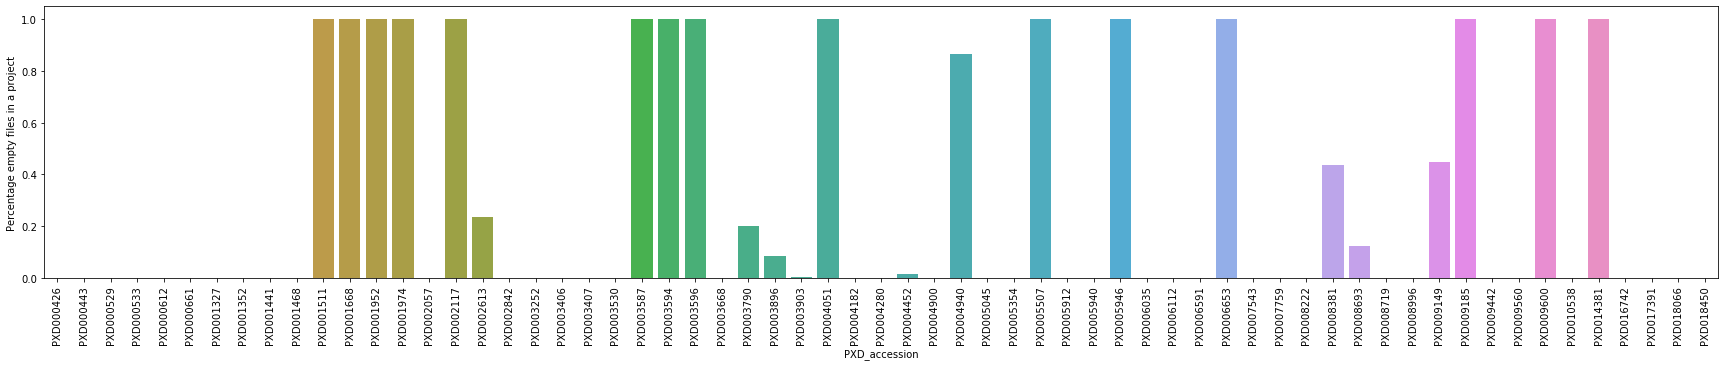

In [5]:
# Percentage of files in a project that have no identifications
# For more detailed info, see 'summary_stats_data.ipynb

plt.figure(figsize=(30,5))
plt.xticks(rotation=90)


identification_project = full_df[full_df.proteins == 0].groupby("PXD_accession").count()["assay_id"] / full_df.groupby("PXD_accession").count()["assay_id"]
identification_project.fillna(0, inplace = True)
sns.barplot(x = identification_project.index, y = identification_project)
plt.ylabel("Percentage empty files in a project")

Failed files: 1209


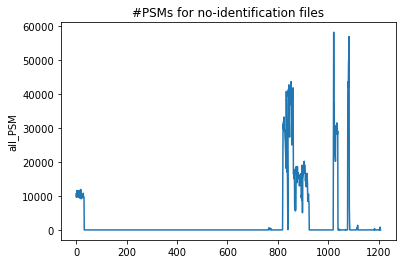

In [6]:
# Some files do contain many PSMs yet have not identified anything
print('Failed files: {}'.format(full_df[full_df.proteins == 0].shape[0]))
plt.title("#PSMs for no-identification files")
sns.lineplot(x=range(len(full_df[full_df.proteins == 0].all_PSM)), y=full_df[full_df.proteins == 0].all_PSM)

Filter the empty files out for now

In [5]:
full_df = full_df[full_df.proteins != 0]

In [8]:
full_df.PXD_accession.nunique()

48

In [9]:
full_df.head()

,assay_id,project_id,filename,cell_id,cell_line,disease,treatment,tissue_type,sub_cell,organ_id,PXD_accession,experiment_type,instrument,pmid,all_PSM,sign_PSM,peptides,proteins
0,30960,1815,3B10-1,545,Hep3B,hepatocellular carcinoma,/,liver,/,None,PXD000533,/,/,/,11014,10578,9705,2401
1,30961,1815,3B10-2,545,Hep3B,hepatocellular carcinoma,/,liver,/,None,PXD000533,/,/,/,11530,11036,10104,2449
2,30962,1815,3B1-1,545,Hep3B,hepatocellular carcinoma,/,liver,/,None,PXD000533,/,/,/,11558,10874,9947,2620
3,30963,1815,3B11-1,545,Hep3B,hepatocellular carcinoma,/,liver,/,None,PXD000533,/,/,/,11821,11205,9940,2542
4,30964,1815,3B11-2,545,Hep3B,hepatocellular carcinoma,/,liver,/,None,PXD000533,/,/,/,11704,11014,9757,2449


Add experiment_type, instrument, pmid data. This is stored in "project_annotation_update.csv"

In [10]:
project_metadata = pd.read_csv("../Metadata/project_metadata.csv", sep=";")

In [11]:
def fn(row):
    PXD, digestion, instrument, pmid = project_metadata[project_metadata.accession == row.PXD_accession].values[0]
    return digestion, instrument, pmid


applied_df = full_df.apply(lambda row: fn(row), axis='columns', result_type='expand')
applied_df.rename(columns={0: "experiment_type", 1: "instrument", 2: "pmid"}, inplace=True)
full_df.drop("experiment_type instrument pmid".split(), inplace = True, axis = 1)
full_df = pd.concat([full_df, applied_df], axis=1)

Add pooling metadata

In [159]:
# add annotation of pooling; This is saved in the pooling.log file. The format is INFO:root:filename: poolID
pooling_annotation = {"filename":[], "poolID":[]}

with open("../Atlas_creation/pooling.log", "r") as logfile:
    for line in logfile:
        filename = line.split(":")[-2]
        poolID = line.split(":")[-1]

        pooling_annotation["filename"].append(filename)
        pooling_annotation["poolID"].append(poolID.strip())

pooling_annotation = pd.DataFrame(pooling_annotation)

pooling_annotation2 = pd.read_excel("../Metadata/annotation_excel4.xlsx", engine="openpyxl")
pooling_annotation2 = pooling_annotation2[pooling_annotation2.Useable == "yes"]
pooling_annotation2["RAW"] = pooling_annotation2.RAW.apply(lambda x: str(x).split(".")[0])

pooling_annotation3 = pd.read_excel("../Metadata/annotation_PXD018450.xlsx", engine="openpyxl")
pooling_annotation3["pool_id"] = pooling_annotation3.pool_id.apply(lambda x: str(x))

In [160]:
def generate_pool_table(full_df, metadata1, metadata2, metadata3):
    pool_id_table = {"filename": [], "pool_id": []}
    for i, row in full_df.iterrows():
        file = row.filename
        pool_id_table["filename"].append(file)

        meta1 = metadata1[metadata1.filename == file].poolID
        meta2 = metadata2[metadata2.RAW == file].pool_id
        meta3 = metadata3[metadata3.RAW == file].pool_id

        if len(meta2) == 1:
            pool_id_table["pool_id"].append(meta2.values[0])
            continue

        elif len(meta1) == 1:
            pool_id_table["pool_id"].append(meta1.values[0])
            continue

        elif len(meta3) == 1:
            pool_id_table["pool_id"].append(meta3.values[0])
            continue
        
        else:
            pool_id_table["pool_id"].append(np.nan)

    return pd.DataFrame(pool_id_table)

In [168]:
pool1 = pd.read_csv("annotation_excel4.csv")
pool1 = pool1[pool1.Useable == "yes"]
pool1["RAW"] = pool1.RAW.apply(lambda x: str(x).split(".")[0])

def change(row):
    row_pool = row.pool_id
    ref_pool = pool1[pool1.RAW == row.RAW]

    if str(row_pool) == "nan":
        if (len(ref_pool) > 0) and (str(row_pool) != str(ref_pool.pool_id.values[0])):
            return str(ref_pool.pool_id.values[0])
        return str(row.pool_id)
    else:
        return str(row.pool_id)

pooling_annotation2["pool_id"] = pooling_annotation2.apply(change, axis = 1)
pooling_annotation2 = pooling_annotation2[pooling_annotation2.PXD != "PXD013615"]

In [169]:
pool_table = generate_pool_table(full_df=full_df, metadata1=pooling_annotation, metadata2=pooling_annotation2, metadata3=pooling_annotation3)

In [174]:
no_annotation_pool = full_df[full_df.filename.isin(pool_table[pool_table.pool_id.isin("? / no_annotation".split())].filename)]
print(no_annotation_pool.shape)

(92, 18)


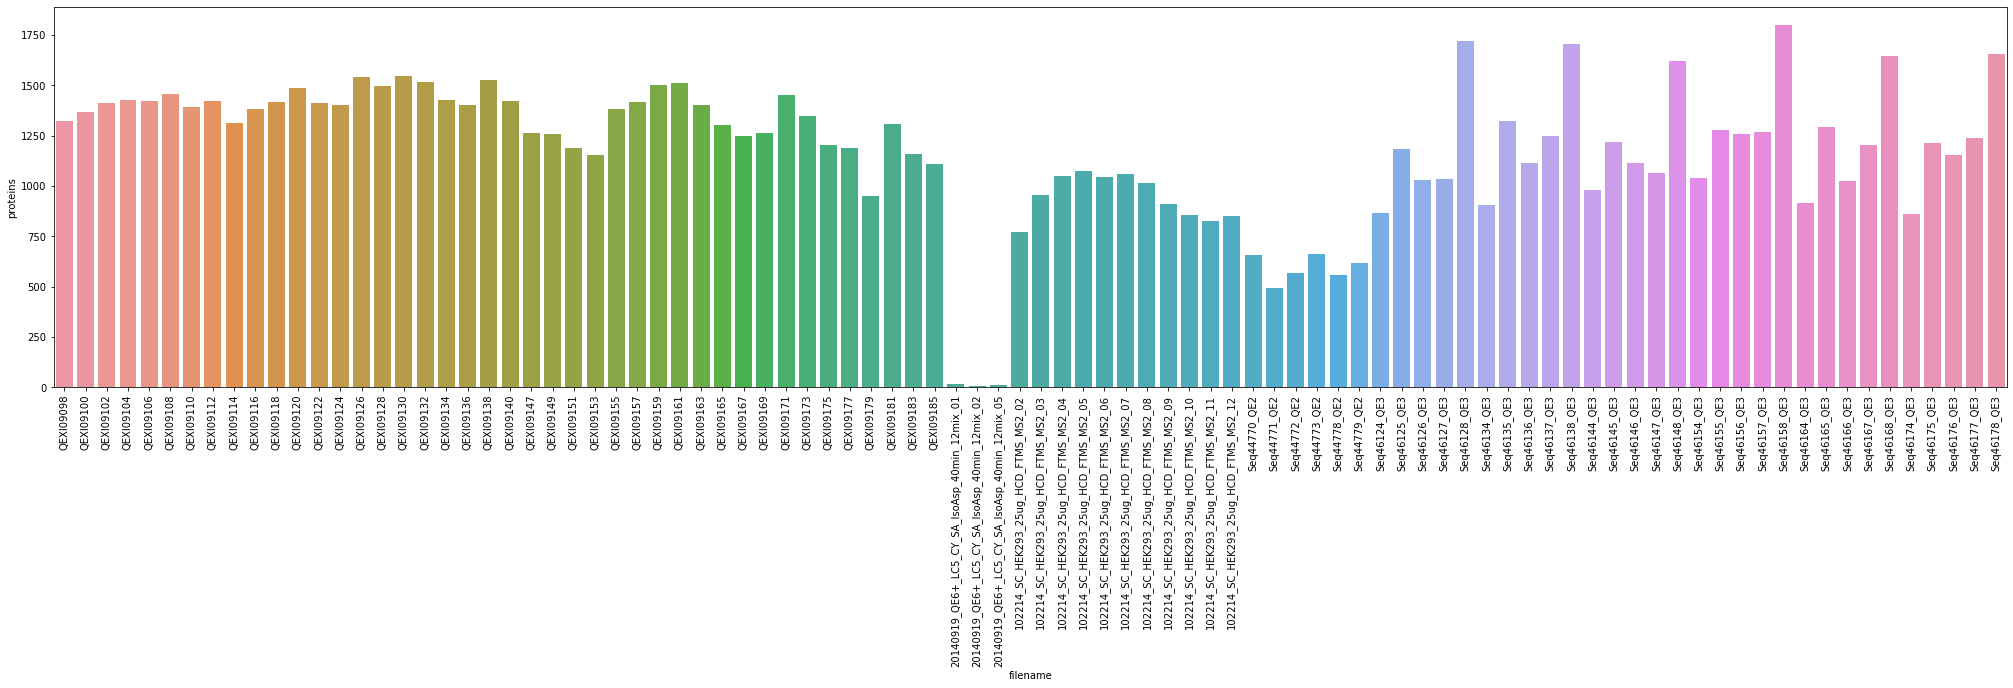

In [175]:
plt.figure(figsize=(35,7))
plt.xticks(rotation=90)
sns.barplot(x=no_annotation_pool.filename, y=no_annotation_pool.proteins)

In [176]:
no_annotation_pool.PXD_accession.unique()

array(['PXD004280', 'PXD006112', 'PXD003896', 'PXD003790'], dtype=object)

In [177]:
pool_table_annot = pool_table[~pool_table.pool_id.isin("? / no_annotation".split())]
pool_table_annot.shape

(4322, 2)

In [179]:
full_df = pd.merge(full_df, pool_table_annot, on="filename")
print(full_df.shape)
full_df.tail()

(4322, 19)


,assay_id,project_id,filename,cell_id,cell_line,disease,treatment,tissue_type,sub_cell,organ_id,PXD_accession,all_PSM,sign_PSM,peptides,proteins,experiment_type,instrument,pmid,pool_id
4317,36435,1872,01481_G02_P015041_S00_N15_R1,636,CRC,colorectal cancer,/,colon,/,None,PXD005354,42831,8512,2790,1239,in-solution,LTQ Orbitrap Velos,29101300,65
4318,36436,1872,01481_G03_P015041_S00_N23_R1,636,CRC,colorectal cancer,/,colon,/,None,PXD005354,23567,4960,1663,663,in-solution,LTQ Orbitrap Velos,29101300,65
4319,36437,1872,01481_H01_P015041_S00_N08_R1,636,CRC,colorectal cancer,/,colon,/,None,PXD005354,52524,9375,2980,1296,in-solution,LTQ Orbitrap Velos,29101300,65
4320,36438,1872,01481_H02_P015041_S00_N16_R1,636,CRC,colorectal cancer,/,colon,/,None,PXD005354,40851,8223,2626,1135,in-solution,LTQ Orbitrap Velos,29101300,65
4321,36439,1872,01481_H03_P015041_S00_N24_R1,636,CRC,colorectal cancer,/,colon,/,None,PXD005354,18078,3788,1116,435,in-solution,LTQ Orbitrap Velos,29101300,65


In [187]:
full_df["tissue_type"] = full_df.tissue_type.replace("T-cell", "blood")

In [189]:
full_df.to_csv("unified_metadata.csv")

---

Add ionbot version

In [7]:
spectra3 = pd.read_csv("../Database/parsedNewFiles.csv")
ionbot_version1 = pd.read_csv("../Database/parsed_manual_meta2.csv", index_col="Unnamed: 0")[["PXD", "ionbot_version"]]
spectra3["ionbot_version"] = spectra3.file_path.apply(lambda x: x.split("/")[8])
ionbot_version2 = spectra3[["PXD", "ionbot_version"]]

ionbot_version = {"PXD": {}, "ionbot_version": {}}
for pxd in set(ionbot_version1.PXD.unique().tolist() + ionbot_version2.PXD.unique().tolist()):
    if pxd in ionbot_version1.PXD.unique() and pxd in ionbot_version2.PXD.unique():
        if ionbot_version1[ionbot_version1.PXD == pxd].ionbot_version.unique() != ionbot_version2[ionbot_version2.PXD == pxd].ionbot_version.unique():
            print(f"Non matching versions: {pxd}")
    
    if pxd in ionbot_version1.PXD.unique():
        ionbot_version["PXD"][pxd] = pxd
        ionbot_version["ionbot_version"][pxd] = ionbot_version1[ionbot_version1.PXD == pxd].ionbot_version.unique()[0]

    elif pxd in ionbot_version2.PXD.unique():
        ionbot_version["PXD"][pxd] = pxd
        ionbot_version["ionbot_version"][pxd] = ionbot_version2[ionbot_version2.PXD == pxd].ionbot_version.unique()[0]
    
    else:
        print(f"Error, {pxd} not found")

ionbot_version = pd.DataFrame(ionbot_version)

meta = pd.read_csv("unified_metadata.csv")
meta["ionbot_version"] = meta.PXD_accession.apply(lambda x: ionbot_version[ionbot_version.PXD == x].ionbot_version.values[0])

In [61]:
meta.to_csv("unified_metadata.csv", index = False)